# Evolution of Einstein's equations minimally coupled to a scalar field in Spherical Symmetry with Double Null coordinates

# Initial data constants definition

In [697]:
s1,s2=1,1;
R01,R02,R03=4,4,10; 
P=0.3;#0.3716643061488867; #0.5272613525390625; #0.5276824951171875; #1; #0.07646560668945312 #0.12894058227539062;  #0.6692302294921875; #0.66875; #0.69374; #0.6666;
P3=0;
B=0; 
D=0;
Rd=5;
sd=2;
#b=-1; #resolution trick constants
#d=5;
#Lambda=-0.001; #cosmological constant just in case

In [698]:
ori=0.0; #1.9; #Origin 
y0=[1.0 0.0]; #Crr(1,ori)+1.0; #1;  #Origin value of the Cr function appearing in the constraint

# Initial data , setting length of the domain and discretization


In [699]:
m=5;
N=2.0^m*100.0;
Rf=40.0;
dx=Rf/N;
R1=range(ori, stop=Rf+dx, step=dx);
dt=dx*0.4;   #for backwards integration flip this sign, but flip the dissipation sign too
#dt=minimum(1 ./(1 .+ exp.(b .*R1.^2 .+d)))*dx*0.4;
Nt=100.0*2^m;
Tf=Nt*dt; #final time
println("the final time is ", Tf)

the final time is 16.000000000000004


In [700]:
epsilon=0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)
omicron=0.0;#setting dissipation operator to O(R^2)
omega=120.0; #1/dx^4; #1/dx^2; #/dx^4;

#Runge-Kutta integrator for each time step i

In [701]:
R =range(ori-2.0*dx, stop=Rf+2.0*dx, step=dx); #change in case you want to evolve a symmetric domain
#midpoint=findall(R.==0)[]
#R=R .-dx/2.0;
#R1=R1 .-dx/2.0;
L=length(R);
println("step size is  ", dx)

T=range(dt,stop=Tf,step=dt)
println("the time step is ", dt)

step size is  0.0125
the time step is 0.005000000000000001


In [702]:
include("./DoubleNullgauge.jl");
#include("./EHfinder.jl");

In [703]:
DNconstraintRHS(y0,R1[1])

2×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0
 1.0

# Solving for the constraint with double resolution

In [704]:
sRc=rungekutta4(DNconstraintRHS, y0, R1); 
#using CSV, Tables
#CSV.write("/home/kri/Documents/DATA/Cr_initial_data_SphGR_gaussian.csv", Tables.table(initial_data), writeheader=false)

## Evolving with staggered grid  with one resolution lower and passing half the initial data

In [706]:
#adding ghost positions
sRcL=zeros(L,2);
sRcL[3:L-2,:]=sRc[1:L-4,:]; #sRc[2:2:length(sRc[:,1])+1,:];

# Defining the initial state array for the evolution

In [707]:
#state_array=[zeros(L) zeros(L) zeros(L) R ones(L) -ones(L) scalar_timeder(R) scalar_spaceder(R) scalar_field(R)];
state_array=[zeros(L) zeros(L) zeros(L) sRcL[:,2] sRcL[:,1] -sRcL[:,1] scalar_timeder(R) scalar_spaceder(R) scalar_field(R)];
state_array=ghost(state_array);

3205×9 Matrix{Float64}:
 0.0  0.0  0.0  -0.025   1.0       -1.0       0.0  -4.1987e-8   2.74604e-8
 0.0  0.0  0.0  -0.0125  1.0       -1.0       0.0  -2.09055e-8  2.70676e-8
 0.0  0.0  0.0   0.0     1.0       -1.0       0.0   0.0         2.6937e-8
 0.0  0.0  0.0   0.0125  1.0       -1.0       0.0   2.09055e-8  2.70676e-8
 0.0  0.0  0.0   0.025   1.0       -1.0       0.0   4.1987e-8   2.74604e-8
 0.0  0.0  0.0   0.0375  1.0       -1.0       0.0   6.34218e-8  2.81187e-8
 0.0  0.0  0.0   0.05    1.0       -1.0       0.0   8.53897e-8  2.90482e-8
 0.0  0.0  0.0   0.0625  1.0       -1.0       0.0   1.08074e-7  3.02565e-8
 0.0  0.0  0.0   0.075   1.0       -1.0       0.0   1.31664e-7  3.17538e-8
 0.0  0.0  0.0   0.0875  1.0       -1.0       0.0   1.56353e-7  3.35526e-8
 0.0  0.0  0.0   0.1     1.0       -1.0       0.0   1.82346e-7  3.5668e-8
 0.0  0.0  0.0   0.1125  1.0       -1.0       0.0   2.09852e-7  3.81176e-8
 0.0  0.0  0.0   0.125   1.0       -1.0       0.0   2.39095e-7  4.09216e-8
 ⋮ 

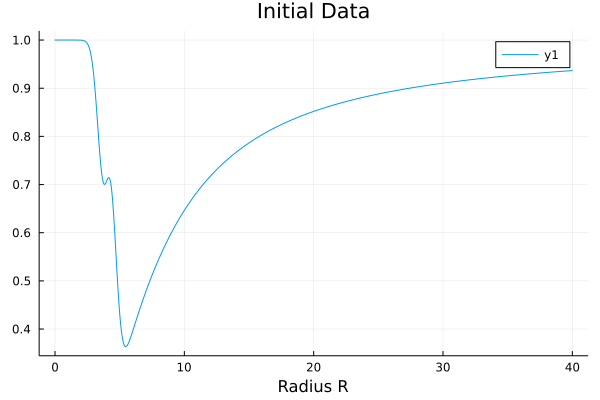

In [709]:
using Plots #showing initial data and the initial status of the horizon finder
plot(R, (state_array[:,5]), xaxis="Radius R",title="Initial Data")

In [710]:
#truncation error
using Peaks
findmaxima(state_array[:,9])[2]*dx^2

1-element Vector{Float64}:
 1.8700419393817164e-5

 ## Evolution

In [711]:
using ProgressMeter
ah=2; #adding excision set to 0 , without excision set to 2
AH=0;
AHloc=zeros(length(T),3);
AHloc[:,1]=T;
ex=0;
@showprogress for k in 1:length(T)
    if isnan(state_array[3,2])
        print("boom")
        break
    end
    #if (abs(state_array[3,2])>0) && ah==0
    #    ah=k
    #    println("origin touched at T=$(T[ah])")
    #end
    if (length(filter(x-> x<0, state_array[:,5]))!=0)
        if AH==0;
            #.;#.-2;
            #ah=1;
            if AH==0
                global AH=k;
            println([T[AH], AH])
            end
        end
        break
        aux=findall(state_array[:,5] .< 0)[length(findall(state_array[:,5].<0))];
            AHloc[k,2]=aux;
            AHloc[k,3]=state_array[aux,4];
        if length(filter(x-> x<0, state_array[:,5]))>0 && ah!=2 && ex==0
            global ex=findall(state_array[:,5] .<0)[length(findall(state_array[:,5].<0))];
            #print("excsision starts now")
            #epsilon=0;
        end
    end
    if ex!=0 && ah!=2
    state_array=extrapolation(state_array,ex)
    state_array=rungekutta4molstep(CRRHSexcision,state_array,T,k,ex) 
    else
    state_array=rungekutta4molstep(DNRHS,state_array,T,k,0)   
    state_array=ghost(state_array)
    end
            #if mod(k,30)==1
    using CSV, Tables
    CSV.write("/home/kri/Documents/DATA/DNGauge/time_step$k.csv", Tables.table(state_array), writeheader=false)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:09:53


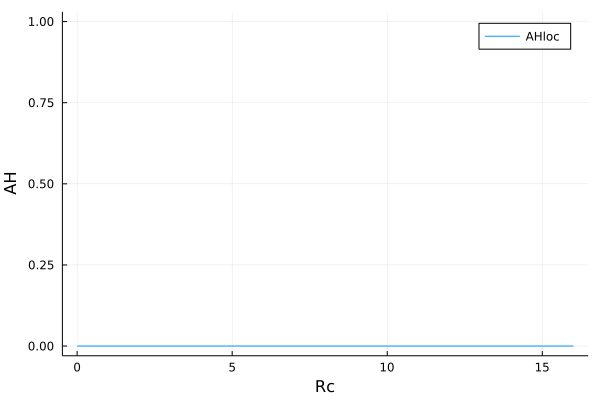

In [712]:
plot(AHloc[:,1],AHloc[:,3], labels="AHloc", ylabel="AH", xlabel="Rc")

## Movie of the evolution

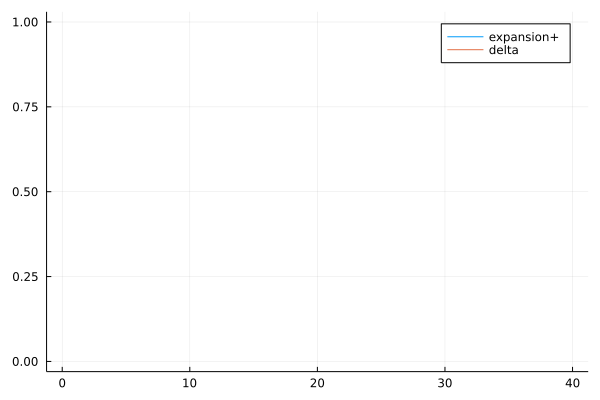

In [ ]:
#making a movie of the evolution
global dir="/home/kri/Documents/DATA/DNGauge/"
using Plots, CSV, DataFrames
import GR
for n in 1:1:length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    #functions3=DataFrame(CSV.File("/home/kri/Documents/DATA/PBHconvergence/time_steps_1/time_step$(n).csv",header=false, delim=","))
    #functions3=DataFrame(CSV.File("/home/kri/Documents/DATA/Crconvergence/Cr_time_steps_1/time_step$(n).csv",header=false, delim=","))
    #functions3=DataFrame(CSV.File("/home/kri/Documents/DATA/time_steps/time_step$n.csv",header=false, delim=","))
     functions3=DataFrame(CSV.File(joinpath(dir,"time_step$n.csv"),header=false, delim=","))
    plot()
        y=functions3.Column1[1:L];
        z=functions3.Column4[1:L];
        w=functions3.Column5[1:L];
        v=functions3.Column2[1:L];
        u=functions3.Column9[1:L];
    d=round(T[n],digits=1)
    if false
    if length(filter(x-> x<0.0, (1.0 .+functions3.Column2)))!=0
        a=findall((1.0 .+functions3.Column2).<0.0)[length(findall((1.0 .+functions3.Column2).<0.0))]
        #b=findall( (1 .+functions3.Column2).<0)[1]
        plot!([x[a-2]], seriestype="vline",labels="excision") 
        #plot!([x[b]],seriestype="vline")
        Mass=round(ADM(Matrix(functions3)),digits=4);
        plot!(title="AH@ R=$(x[a]), T=$d, ADMmass=$Mass")
        #global AHt=n;
        #break #pause the video to see the behaviour of the Kr invariant before formation
    else
        Mass=round(ADM(Matrix(functions3)),digits=4);
        plot!(title="T=$d , ADMmass=$Mass")
    end
    end
    plot!(R, [w u], labels=["expansion+" "delta" "timeder" "spaceder" "scalar"]) |> display #ADM mass
    
    #png("/home/kri/Documents/DATA/time_steps/imagesfixedbackground/$n.png")
    #[y z u v]
    #(1 .+z)./(1 .-z)
    #( x .*(1 .-exp.(-y./2)./sqrt.(1 .-z))) ADMmass
    #plot!(x, [y w v u K W (1 .+z)./(1 .-z)],xlims=(0,20)) |> display
    #(z./(2 .-z))
    #plot(x, [y z w v u ((1 .+ x.*z)./(1 .- x.*z)) K], title="T=$d", ylims=(-0.3,0.3),xlims=(0,5)) |> display
end